# Ownership and Sales Price Analysis

hide company flag- does the model predict the value should be what it actually was sold for?

naive approach, same buyer buying more than 2 properties in the time period -> investor



merge appeals too?

interactive map over years showing investor activity?

In [1]:
import polars as pl
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
plt.style.use('ggplot')

In [2]:
atl_sales_parcel = pl.read_csv('../output/geocoded/csv/atl_sales_parcel_neighborhoods.csv',
                               infer_schema_length=0)

In [3]:
two_neighborhoods = atl_sales_parcel.filter(
    (pl.col('neighborhood') == 'Thomasville Heights') |
    (pl.col('neighborhood') == 'South Atlanta')
)

In [11]:
def create_clusters(df: pl.DataFrame, clusters: dict = {}) -> None:
    #size = len(df)

    if not clusters:
        row = df.row(0)
        clusters[row[0]] = []

    for count, row in enumerate(df.rows()):
        #print('{} / {}'.format(count, size))
        ratio = process.extract(row[0], list(clusters.keys()), scorer=fuzz.WRatio, limit=1)
        if ratio[0][1] > 90:
            clusters[ratio[0][0]] = clusters[ratio[0][0]] + [row[0]]
        else:
            clusters[row[0]] = []

    return clusters

def create_clusters_addr(df: pl.DataFrame, clusters: dict = {}) -> None:
    #size = len(df)

    if not clusters:
        row = df.row(0)
        clusters[row[0]] = [row[1]]

    print(clusters)
    for count, row in enumerate(df.rows()):
        #print('{} / {}'.format(count, size))
        try:
            clusters[row[0]] = clusters[row[0]] + [row[1]]
        except:
            clusters[row[0]] = [row[1]]

    return clusters

def create_clusters_eff(df: pl.DataFrame, clusters: dict = {}) -> None:
    #size = len(df)

    if not clusters:
        row = df.row(0)
        clusters[row[0]] = [row[1]]

    for count, row in enumerate(df.rows()):
        #print('{} / {}'.format(count, size))
        ratio = process.extract(row[0], list(clusters.keys()), scorer=fuzz.WRatio, limit=1)
        if ratio[0][1] > 80:
            if clusters[ratio[0][0]][0] == row[1]:
                clusters[ratio[0][0]] = clusters[ratio[0][0]] + [row[0]]
        else:
            clusters[row[0]] = [row[1]]

    return clusters

def match(row: tuple, clusters: dict, match_col: str) -> str:
    for key in clusters.keys():
        ratio = process.extract(row[match_col], list(clusters.keys()), scorer=fuzz.WRatio, limit=1)
        if ratio[0][1] > 90:
            return ratio[0][0]

    return None

def match_eff(row: tuple, clusters: dict) -> str:
    for key in clusters.keys():
        if row['own_adrno'] == clusters[key][0]:
            ratio = process.extract(row['own1'], list(clusters.keys()), scorer=fuzz.WRatio, limit=1)
            if ratio[0][1] > 70:
                return ratio[0][0]

    return None

In [5]:
own_name_clusters = create_clusters(
    two_neighborhoods.select(
        pl.col('own1'),
        pl.col('own_adrno')
    )
)

In [6]:
grantee_name_clusters = create_clusters(
    two_neighborhoods.select(
        pl.col('grantee')
    )
)

In [7]:
grantor_name_clusters = create_clusters(
    two_neighborhoods.select(
        pl.col('grantor')
    )
)

In [8]:
matched_neighborhoods = two_neighborhoods.with_columns(
    pl.struct(['own1', 'own_adrno'])
    .apply(lambda row: match(row, own_name_clusters))
    .alias('match_owner')
)

In [12]:
matched_neighborhoods = matched_neighborhoods.with_columns(
    pl.struct(['grantee'])
    .apply(lambda row: match(row, grantee_name_clusters, 'grantee'))
    .alias('match_grantee')
)

In [13]:
matched_neighborhoods = matched_neighborhoods.with_columns(
    pl.struct(['grantor'])
    .apply(lambda row: match(row, grantor_name_clusters, 'grantor'))
    .alias('match_grantor')
)

In [23]:
matched_neighborhoods[['grantee', 'match_grantee', 'grantor', 'match_grantor', 'match_owner', 'own1']].sample(5)

grantee,match_grantee,grantor,match_grantor,match_owner,own1
str,str,str,str,str,str
"""JOHNSON DONALD…","""JOHNSON DONALD…","""BRENDA GRIFFIE…","""BRENDA GRIFFIE…","""MC KINNEY JANI…","""MC KINNEY JANI…"
"""TOTAL HOUSING …","""TOTAL HOUSING …","""PETTY RON""","""PETTY RON""","""TOTAL HOUSING …","""TOTAL HOUSING …"
"""CHARIS SOUTH A…","""CHARIS SOUTH A…","""BELFARE LLC""","""BELFARE LLC""","""CHARIS SOUTH A…","""CHARIS SOUTH A…"
"""PINNACLE PROPE…","""PINNACLE PROPE…","""PINNACLE PROPE…","""PINNACLE PROPE…","""PINNACLE PROPE…","""PINNACLE PROPE…"
"""ALLEANZA REAL …","""ALLEANZA REAL …","""PAVARINI EDUAR…","""PAVARINI EDUAR…","""RAPHAEL ISABEL…","""RAPHAEL ISABEL…"


In [24]:
matched_neighborhoods = matched_neighborhoods.join(
    (
        matched_neighborhoods.groupby(['match_owner'])
        .count().filter(
            pl.col('count') > 1
        ).sort(by='count', descending=True)
    ),
    how='left',
    on='match_owner'
).with_columns(
    pl.when(pl.col('count').is_not_null())
    .then(True)
    .otherwise(False)
    .keep_name()
).select(
    pl.col('count').cast(pl.Boolean),
    pl.col('*').exclude('count')
).rename({'count': 'investor'})

In [26]:
matched_neighborhoods = matched_neighborhoods.join(
    (
        matched_neighborhoods.groupby(['match_grantor'])
        .count().filter(
            pl.col('count') > 1
        ).sort(by='count', descending=True)
    ),
    how='left',
    on='match_grantor'
).with_columns(
    pl.when(pl.col('count').is_not_null())
    .then(True)
    .otherwise(False)
    .keep_name()
).select(
    pl.col('count').cast(pl.Boolean),
    pl.col('*').exclude('count')
).rename({'count': 'grantor_investor'})

In [27]:
matched_neighborhoods = matched_neighborhoods.join(
    (
        matched_neighborhoods.groupby(['match_grantee'])
        .count().filter(
            pl.col('count') > 1
        ).sort(by='count', descending=True)
    ),
    how='left',
    on='match_grantee'
).with_columns(
    pl.when(pl.col('count').is_not_null())
    .then(True)
    .otherwise(False)
    .keep_name()
).select(
    pl.col('count').cast(pl.Boolean),
    pl.col('*').exclude('count')
).rename({'count': 'grantee_investor'})

In [28]:
matched_neighborhoods = matched_neighborhoods.drop(columns=['index_right'])

In [33]:
print(matched_neighborhoods.groupby('match_owner').count().sort(by='count',descending=True))

shape: (1_088, 2)
┌───────────────────────────────────┬───────┐
│ match_owner                       ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ CHARIS SOUTH ATLANTA LLC          ┆ 51    │
│ HABITAT FOR HUMANITY IN ATLANTA … ┆ 42    │
│ RCA SUPPORT CORPORATION           ┆ 32    │
│ MAPLE STREET RE LLC               ┆ 29    │
│ …                                 ┆ …     │
│ SHOPES AT CENTERVILLE HIGHWAY LL… ┆ 1     │
│ THORNTON RAVEN                    ┆ 1     │
│ JACKSON URAL E & BRENDA PAYE SMI… ┆ 1     │
│ ROJAS EDGAR A MENDEZ &            ┆ 1     │
└───────────────────────────────────┴───────┘


In [29]:
print(two_neighborhoods.groupby('own1').count().sort(by='count', descending=True))

shape: (1_140, 2)
┌───────────────────────────────────┬───────┐
│ own1                              ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ CHARIS SOUTH ATLANTA LLC          ┆ 51    │
│ HABITAT FOR HUMANITY IN ATLANTA … ┆ 38    │
│ RCA SUPPORT CORPORATION           ┆ 32    │
│ MAPLE STREET RE LLC               ┆ 29    │
│ …                                 ┆ …     │
│ NEW FAITH HILL APARTMENTS LLC     ┆ 1     │
│ MANOR PARTNERS VI LLC             ┆ 1     │
│ DCS REALTY LLC                    ┆ 1     │
│ ELLIISON WILLIAMS BONITA VANESSA  ┆ 1     │
└───────────────────────────────────┴───────┘


In [30]:
print(
    two_neighborhoods.groupby(['own_adrno', 'own_adrstr'])
    .count().filter(
        pl.col('count') > 1
    ).sort(by='count', descending=True)
)

shape: (438, 3)
┌───────────┬───────────────┬───────┐
│ own_adrno ┆ own_adrstr    ┆ count │
│ ---       ┆ ---           ┆ ---   │
│ str       ┆ str           ┆ u32   │
╞═══════════╪═══════════════╪═══════╡
│ 228       ┆ MARGARET      ┆ 50    │
│ 519       ┆ MEMORIAL      ┆ 36    │
│ 420253    ┆ PO BOX 420253 ┆ 31    │
│ 750       ┆ GLENWOOD      ┆ 27    │
│ …         ┆ …             ┆ …     │
│ 585       ┆ MCWILLIAMS    ┆ 2     │
│ 87        ┆ BROWN         ┆ 2     │
│ 4249      ┆ STATE ROAD 7  ┆ 2     │
│ 10664     ┆ VILLAGE       ┆ 2     │
└───────────┴───────────────┴───────┘


In [31]:
sum((
    two_neighborhoods.groupby(['own_adrno', 'own_adrstr'])
    .count().filter(
        pl.col('count') > 1
    )
)['count'])

1640

In [32]:
sum((
    matched_neighborhoods.groupby(['match_owner'])
    .count().filter(
        pl.col('count') > 1
    )
)['count'])

1556

In [34]:
print(two_neighborhoods.groupby(['own_adrno', 'own_adrstr']).count().sort(by='count', descending=True))

shape: (1_016, 3)
┌───────────┬───────────────┬───────┐
│ own_adrno ┆ own_adrstr    ┆ count │
│ ---       ┆ ---           ┆ ---   │
│ str       ┆ str           ┆ u32   │
╞═══════════╪═══════════════╪═══════╡
│ 228       ┆ MARGARET      ┆ 50    │
│ 519       ┆ MEMORIAL      ┆ 36    │
│ 420253    ┆ PO BOX 420253 ┆ 31    │
│ 750       ┆ GLENWOOD      ┆ 27    │
│ …         ┆ …             ┆ …     │
│ 1226      ┆ KIPLING       ┆ 1     │
│ 2025      ┆ TURNER        ┆ 1     │
│ 1683      ┆ NORTH PELHAM  ┆ 1     │
│ 5270      ┆ SUNSET MAPLE  ┆ 1     │
└───────────┴───────────────┴───────┘


In [35]:
two_neighborhoods.filter(
    (pl.col('own_zip') == 'MARGARET') |
    (pl.col('own_adrno') == '228')
)['own1'].unique().to_list()

['THE RON CLARK ACADEMY INC',
 'RCA SUPPORT CORPORATION',
 'RON CLARK ACADEMY INC THE']

In [36]:
two_neighborhoods.filter(
    (pl.col('own_adrno') == '650043')
)['own1'].unique().to_list()

['FEDERAL NATIONAL MORTGAGE ASSOCIATION',
 'FEDERAL NATIONAL MORTGAGE',
 'FEDERAL NATIONAL MORTGAGE ASSN',
 'FEDERAL NATL MTG ASSN']

In [37]:
two_neighborhoods.filter(
    (pl.col('own_adrstr') == 'MEMORIAL') |
    (pl.col('own_adrno') == '519')
)['own1'].unique().to_list()

['HABITAT FOR HUMANITY ATLANTA INC',
 'HOLLINGSWORTH GEORGE A',
 'UMOJA CHINUA T',
 'HABITAT FOR HUMANITY IN ATLANTA INC.',
 'HABITAT FOR HUMANITY IN ATLANTA INC']

In [38]:
two_neighborhoods.filter(
    (pl.col('own_adrno') == '420253') &
    (pl.col('own_adrstr') == 'PO BOX 420253')
)['own1'].unique().to_list()

['MAPLE STREET RE LLC', 'CENTURY FUND LLC']

In [39]:
print(matched_neighborhoods.groupby('match_grantee').count().sort(by='count',descending=True))

shape: (1_340, 2)
┌───────────────────────────────────┬───────┐
│ match_grantee                     ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ CHARIS SOUTH ATLANTA LLC          ┆ 40    │
│ HABITAT FOR HUMANITY IN ATLANTA … ┆ 32    │
│ RCA SUPPORT CORPORATION           ┆ 32    │
│ MAPLE STREET RE LLC               ┆ 29    │
│ …                                 ┆ …     │
│ JACKSON LAURIE B  ET AL           ┆ 1     │
│ DALE DRAKE GARDNER                ┆ 1     │
│ SUMNER IBRAHIM &                  ┆ 1     │
│ MC CLELLAND JAMES                 ┆ 1     │
└───────────────────────────────────┴───────┘


In [124]:
len(matched_neighborhoods.filter(pl.col('grantee_investor') == True))

596

In [ ]:
len(matched_neighborhoods.filter(pl.col('grantor_investor') == True))

In [40]:
print(matched_neighborhoods.groupby('match_grantor').count().sort(by='count',descending=True))

shape: (1_561, 2)
┌───────────────────────────────────┬───────┐
│ match_grantor                     ┆ count │
│ ---                               ┆ ---   │
│ str                               ┆ u32   │
╞═══════════════════════════════════╪═══════╡
│ CHARIS COMMUNITY HOUSING, INC.    ┆ 39    │
│ CHARIS SOUTH ATLANTA LLC          ┆ 33    │
│ RON CLARK ACADEMY INC THE         ┆ 32    │
│ HABITAT FOR HUMANITY IN ATLANTA … ┆ 25    │
│ …                                 ┆ …     │
│ GREEN JEFFREY MICHAEL             ┆ 1     │
│ RILEY BERNICE THOMAS              ┆ 1     │
│ NEPTUNE CAPITAL LLC               ┆ 1     │
│ PRESERVATION VIEW LLC             ┆ 1     │
└───────────────────────────────────┴───────┘


## Analysis
---

In [41]:
matched_neighborhoods = matched_neighborhoods.drop_nulls(subset=['salesprice'])

In [42]:
matched_neighborhoods = matched_neighborhoods.select(
    pl.col('salesprice').cast(pl.Float64),
    pl.col('*').exclude('salesprice')
).filter(
    (pl.col('salesprice') > 5000) &
    (pl.col('salesprice') < 300000)
)

In [43]:
matched_neighborhoods = matched_neighborhoods.select(
    pl.col('sale_year').cast(pl.Int16),
    pl.col('*').exclude('sale_year')
)

In [44]:
matched_neighborhoods['salesprice'].describe()

statistic,value
str,f64
"""count""",1335.0
"""null_count""",0.0
"""mean""",74250.945318
"""std""",64141.612283
"""min""",5100.0
"""max""",293000.0
"""median""",53500.0
"""25%""",24000.0
"""75%""",107700.0


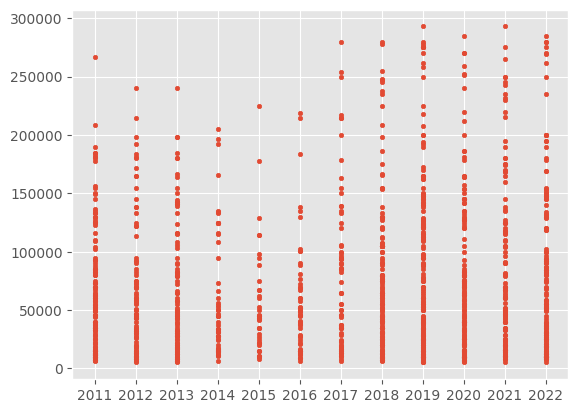

In [46]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['taxyr'].sort(),
           matched_neighborhoods['salesprice'],
           s=10)
plt.show()

In [47]:
len(matched_neighborhoods)

1335

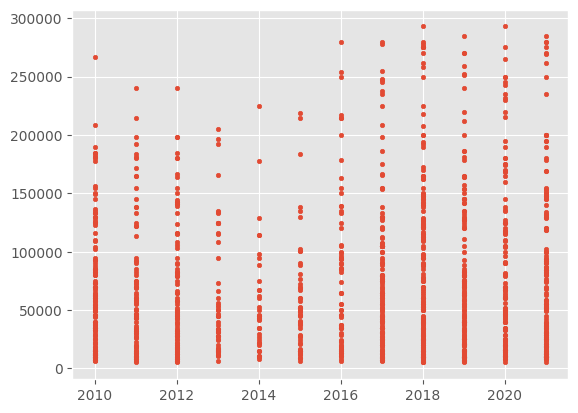

In [49]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].sort(),
           matched_neighborhoods['salesprice'],
           s=10)
plt.show()

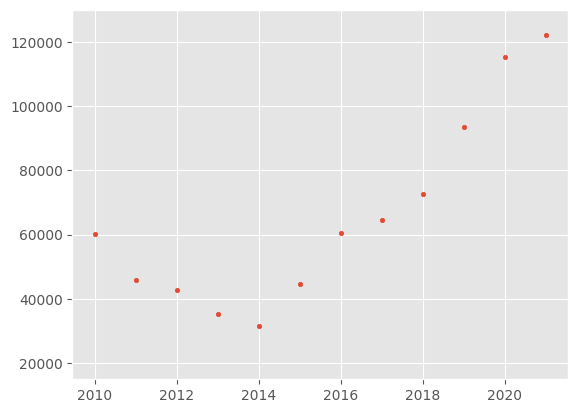

In [50]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           matched_neighborhoods.groupby('sale_year').mean().sort(by='sale_year')['salesprice'],
           s=10)
ax.set_ylim([15000, 130000])
plt.show()

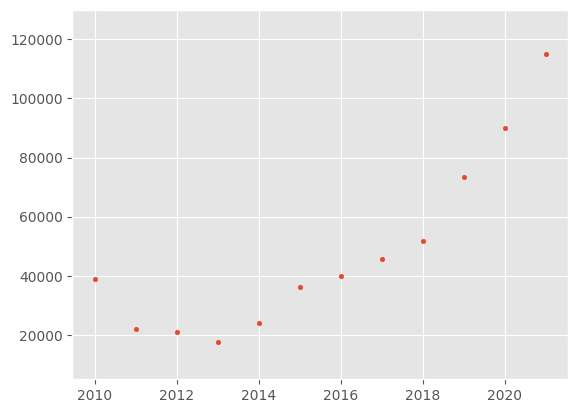

In [51]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           matched_neighborhoods.groupby('sale_year').median().sort(by='sale_year')['salesprice'],
           s=10)
ax.set_ylim([5000, 130000])
plt.show()

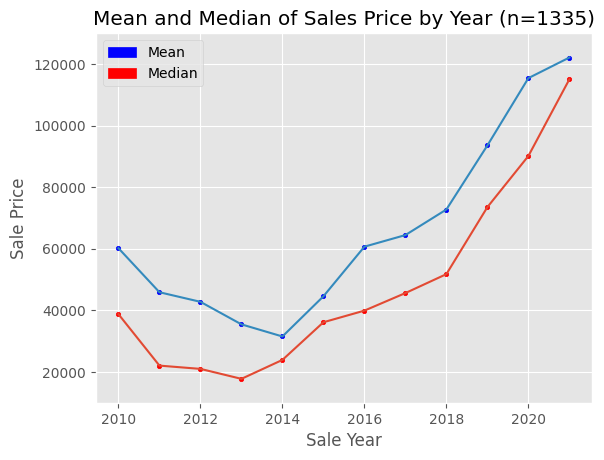

In [75]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           matched_neighborhoods.groupby('sale_year').mean().sort(by='sale_year')['salesprice'],
           s=10,
           color='blue')
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           matched_neighborhoods.groupby('sale_year').median().sort(by='sale_year')['salesprice'],
           s=10,
           color='red')
plt.plot(matched_neighborhoods['sale_year'].unique(), matched_neighborhoods.groupby('sale_year').median().sort(by='sale_year')['salesprice'])
plt.plot(matched_neighborhoods['sale_year'].unique(), matched_neighborhoods.groupby('sale_year').mean().sort(by='sale_year')['salesprice'])
ax.set_ylim([10000, 130000])
blue_patch = mpatches.Patch(color='blue', label='Mean')
red_patch = mpatches.Patch(color='red', label='Median')
ax.legend(handles=[blue_patch, red_patch])
plt.xlabel('Sale Year')
plt.ylabel('Sale Price')
plt.title('Mean and Median of Sales Price by Year (n=1335)')
plt.show()

### Median is typically below mean; a lot of properties are selling for low values, but a few high outliers are raising the mean.

In [53]:
matched_neighborhoods = matched_neighborhoods.select(
    pl.col('investor').cast(pl.Boolean),
    pl.col('*').exclude('investor')
)
investor_y = matched_neighborhoods.filter(
    pl.col('investor') == True
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']
non_y = matched_neighborhoods.filter(
    pl.col('investor') == False
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']

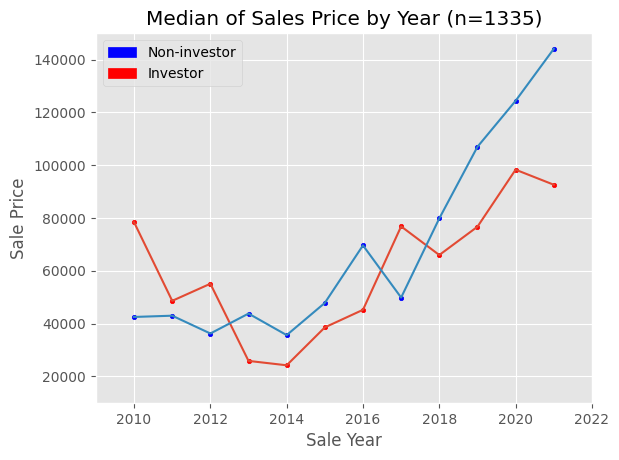

In [78]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           investor_y,
           s=10,
           color='red')
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           non_y,
           s=10,
           color='blue')
plt.plot(matched_neighborhoods['sale_year'].unique(), investor_y)
plt.plot(matched_neighborhoods['sale_year'].unique(), non_y)
ax.set_xlim([2009, 2022])
ax.set_ylim([10000, 150000])
blue_patch = mpatches.Patch(color='blue', label='Non-investor')
red_patch = mpatches.Patch(color='red', label='Investor')
ax.legend(handles=[blue_patch, red_patch])
plt.xlabel('Sale Year')
plt.ylabel('Sale Price')
plt.title('Median of Sales Price by Year (n=1335)')
plt.show()

## Purchases

In [83]:
investor_y = matched_neighborhoods.filter(
    pl.col('grantee_investor') == True
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']
non_y = matched_neighborhoods.filter(
    pl.col('grantee_investor') == False
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']

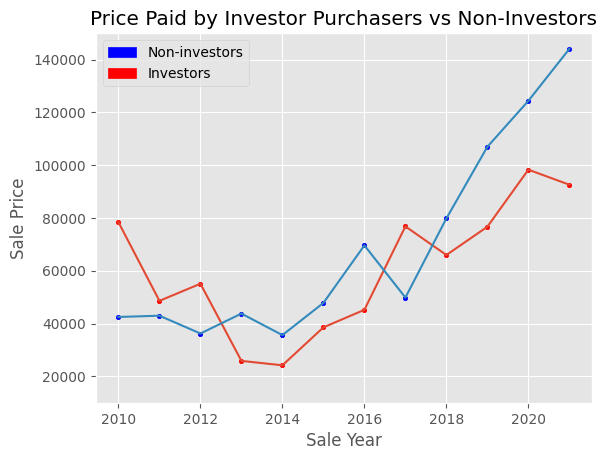

In [84]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           investor_y,
           s=10,
           color='red')
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           non_y,
           s=10,
           color='blue')
plt.plot(matched_neighborhoods['sale_year'].unique(), investor_y)
plt.plot(matched_neighborhoods['sale_year'].unique(), non_y)
ax.set_ylim([10000, 150000])
blue_patch = mpatches.Patch(color='blue', label='Non-investors')
red_patch = mpatches.Patch(color='red', label='Investors')
ax.legend(handles=[blue_patch, red_patch])
plt.xlabel('Sale Year')
plt.ylabel('Sale Price')
plt.title('Price Paid by Investor Purchasers vs Non-Investors')
plt.show()

## Sales

In [85]:
investor_y = matched_neighborhoods.filter(
    pl.col('grantor_investor') == True
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']
non_y = matched_neighborhoods.filter(
    pl.col('grantor_investor') == False
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']

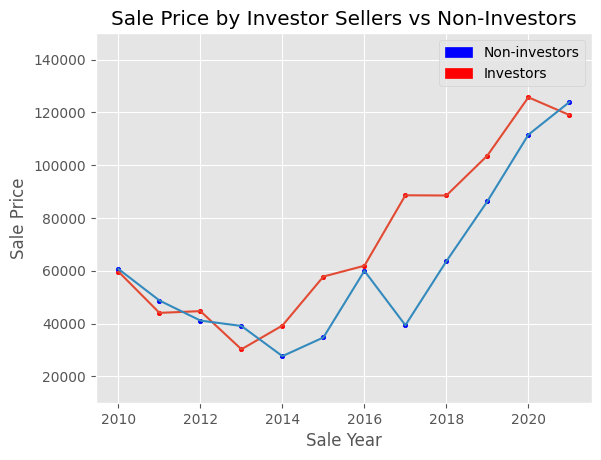

In [86]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           investor_y,
           s=10,
           color='red')
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           non_y,
           s=10,
           color='blue')
plt.plot(matched_neighborhoods['sale_year'].unique(), investor_y)
plt.plot(matched_neighborhoods['sale_year'].unique(), non_y)
ax.set_ylim([10000, 150000])
blue_patch = mpatches.Patch(color='blue', label='Non-investors')
red_patch = mpatches.Patch(color='red', label='Investors')
ax.legend(handles=[blue_patch, red_patch])
plt.xlabel('Sale Year')
plt.ylabel('Sale Price')
plt.title('Sale Price by Investor Sellers vs Non-Investors')
plt.show()

## Gains extracted by investors

In [91]:
print(matched_neighborhoods.groupby('parid_strip').count().sort(by='count', descending=True))

shape: (613, 2)
┌────────────────┬───────┐
│ parid_strip    ┆ count │
│ ---            ┆ ---   │
│ str            ┆ u32   │
╞════════════════╪═══════╡
│ 14005700020159 ┆ 10    │
│ 14005700070071 ┆ 7     │
│ 14005600080444 ┆ 7     │
│ 14005700130057 ┆ 7     │
│ …              ┆ …     │
│ 14005700050339 ┆ 1     │
│ 14005600050561 ┆ 1     │
│ 14005600100580 ┆ 1     │
│ 14005600100606 ┆ 1     │
└────────────────┴───────┘


In [96]:
sum(matched_neighborhoods.filter(
    pl.col('grantee_investor') == True
)['salesprice'])

41184475.0

In [97]:
sum(matched_neighborhoods.filter(
    pl.col('grantor_investor') == True
)['salesprice'])

43922482.0

In [98]:
sum(matched_neighborhoods.filter(
    pl.col('grantor_investor') == True
)['salesprice']) - sum(matched_neighborhoods.filter(
    pl.col('grantee_investor') == True
)['salesprice'])

2738007.0

In [99]:
sum(matched_neighborhoods.filter(
    pl.col('grantee_investor') == False
)['salesprice'])

57940537.0

In [100]:
sum(matched_neighborhoods.filter(
    pl.col('grantor_investor') == False
)['salesprice'])

55202530.0

In [101]:
sum(matched_neighborhoods.filter(
    pl.col('grantor_investor') == False
)['salesprice']) - sum(matched_neighborhoods.filter(
    pl.col('grantee_investor') == False
)['salesprice'])

-2738007.0

In [103]:
sum(matched_neighborhoods['salesprice'])

99125012.0

In [106]:
import plotly.express as px
import geopandas as gpd

In [116]:
gdf = gpd.GeoDataFrame(matched_neighborhoods.to_pandas())
gdf.set_geometry('geometry_pt')

fig = px.scatter_mapbox(gdf,
                        lat=gdf.geometry.y,
                        lon=gdf.geometry.x,
                        hover_name="name",
                        zoom=1)
fig.show()

TypeError: Input must be valid geometry objects: POINT (-84.35699735738648 33.69667324597434)

## Correlation

In [55]:
import numpy as np

In [65]:
ml = matched_neighborhoods.select(
    pl.col('sale_year').cast(pl.Int16),
    pl.col('yrblt').cast(pl.Float32),
    pl.col('rmbed').cast(pl.Float32),
    pl.col('fixbath').cast(pl.Float32),
    pl.col('salesprice')
).drop_nulls(subset=['yrblt', 'rmbed', 'fixbath'])

<Axes: >

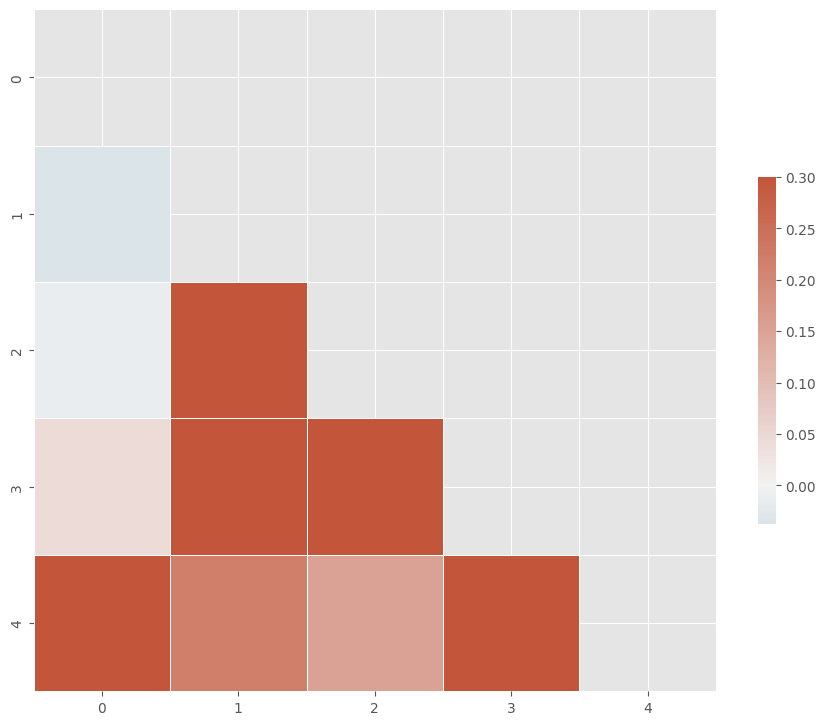

In [66]:
corr = ml.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Create feature variables for the Multiple Linear Regression model

In [ ]:
[['sale_year', 'deed', 'livunit', 'site_adrstr', 'luc', 'calcacres', 'yrblt', 'rmbed', 'fixbath', 'investor']]

In [ ]:
ml = matched_neighborhoods.drop_nulls(subset=['calcacres', 'yrblt', 'rmbed', 'fixbath'])

In [ ]:
x = ml.select(
    pl.col('sale_year').cast(pl.Int16),
    pl.col('yrblt').cast(pl.Float32),
    pl.col('rmbed').cast(pl.Float32),
    pl.col('fixbath').cast(pl.Float32),
)
y = ml.select(
    pl.col('salesprice')
)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.1, random_state=101)

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

In [ ]:
predictions = model.predict(x_test)

In [ ]:
# model evaluation
print(
  'mean_squared_error : ', mean_squared_error(y_test, predictions))
print(
  'mean_absolute_error : ', mean_absolute_error(y_test, predictions))

In [ ]:
matched_neighborhoods = matched_neighborhoods.select(
    pl.col('investor').cast(pl.Boolean),
    pl.col('*').exclude('investor')
)
investor_y = matched_neighborhoods.filter(
    pl.col('investor') == True
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']
non_y = matched_neighborhoods.filter(
    pl.col('investor') == False
).groupby('sale_year').mean().sort(by='sale_year')['salesprice']

In [ ]:
fig, ax = plt.subplots()
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           investor_y,
           s=10,
           color='red')
ax.scatter(matched_neighborhoods['sale_year'].unique(),
           non_y,
           s=10,
           color='blue')

ax.set_xlim([2009, 2021])
ax.set_ylim([10000, 130000])
blue_patch = mpatches.Patch(color='blue', label='Non-investor')
red_patch = mpatches.Patch(color='red', label='Investor')
ax.legend(handles=[blue_patch, red_patch])
plt.xlabel('Sale Year')
plt.ylabel('Sale Price')
plt.title('Median of Sales Price by Year (n=1335)')
plt.show()

bought by investor versus sold by investor

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(data=matched_neighborhoods, x='sale_year', y='salesprice')